### 04 - Neural Networks

#### Let's get to the real deal ML - neural nets, aka Multilayer Perceptrons.

We'll **build a minimal neural net from scratch** and use it to predict a single number from a synthetic dataset.  

**Architecture**: 2 input vars, 1 layer of 4 hidden neurons, one continuous output

## What we'll do
0. Setup & make a tiny synthetic dataset (2 features, 1 target)  
1. Define the loss function (**MSE**)  
2. Define the **forward pass** (with bias via input augmentation)  
3**Backprop**: derive gradients and implement training loop (next, after you confirm)

## 0. Setup & synthetic data

We'll create a small nonlinear target so the hidden layer is actually useful.

In [1]:
import numpy as np

# Reproducibility
rng = np.random.default_rng(42)

# Create synthetic data: N samples, 2 features
N = 2000
x1 = rng.uniform(-2.0, 2.0, size=N)
x2 = rng.uniform(-2.0, 2.0, size=N)
X = np.stack([x1, x2], axis=1)  # shape (N, 2)

# Nonlinear target with a bit of noise
noise = rng.normal(0.0, 0.1, size=N)
y = 1.2 * np.sin(x1) + 0.7 * x2 - 0.3 * x1 * x2 + noise
y = y.reshape(y.size, 1)  # shape (N, 1)

X.shape, y.shape

# Now, let's plot it - this is a rotatable 3-D plot, drag it around to get familiar with the data
import plotly.express as px
import pandas as pd

# Wrap into a DataFrame for nicer plotting
df = pd.DataFrame({"x1": X[:,0], "x2": X[:,1], "y": y.squeeze()})

fig = px.scatter_3d(
    df, x="x1", y="x2", z="y",
    color="y", opacity=0.7,
    title="Interactive 3D view of the dataset"
)
fig.update_traces(marker=dict(size=4))
fig.show()



## 1. Let's Define the loss
### Since we are predicting a single number, our old friend MSE make sense

For a single example with prediction $ \hat{y} $ and true value $ y $:
$$
L = \tfrac{1}{2}(y - \hat{y})^2
$$

For a batch of \(N\) examples:
$$
L = \frac{1}{2N}\sum_{i=1}^{N} \left(y^{(i)} - \hat{y}^{(i)}\right)^2
$$

You probably noticed a difference with the previous MSE:  $ \tfrac{1}{2} $ . This is a nice little trick tat makes the math cleaner - when we take a derivative of something that's squared, we end up with something that's 2x, so if we already have $ \tfrac{1}{2} $, these two conveniently cancel.

In [2]:
def mse_loss(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """
    Mean Squared Error with a 1/2 factor:
    """
    return 0.5 * np.square(y_pred - y_true).mean()

## lets test it real quick
y_pred_fake = np.array([1, 2, 3, 4, 5])
y_actual_fake = np.array([1, 2, 3, 4, 5])

assert 0.0 == mse_loss(y_pred_fake, y_actual_fake)


y_pred_fake = np.array([1, 2, 3, 4, 5])
y_actual_fake = np.array([2, 4, 6, 8, 10])

# 1 + 4 + 9 + 16 + 25 = 55 / (2 * 5) = 5.5

assert 5.5 == mse_loss(y_pred_fake, y_actual_fake)

print("MSE Test Success.")





MSE Test Success.


## 2. Forward pass (with biases via augmentation
We’ll absorb biases by **augmenting** inputs with a constant 1.

- Original input **X** has 2 features, so shape is `(N, 2)`.
- $N$ in this case could be the number of datapoints we run through the network at the same time
- During training N could be the number of datapoints of the entire datasets
- More commonly N would be the number of data points in the training mini-batch 
- Augmented input **X** = `[X  1]` (append a column of ones), so shape is `(N, 3)`.  
  From here on, **X** means the augmented one.

### First layer (input to hidden, 4 neurons)

- Weights `W[1]` has shape `(3, 4)`:
  3 rows = augmented inputs, 4 columns = 4 neurons in the first hidden layer

- Pre-activations:
$$
Z^{[1]} = X\, W^{[1]}
$$ 
- $Z$ is (N by 4), since $X$ is (N by 3) and we dotted it with $W^{[1]}$ which is (3 by 4)


- Activations:
$$
H = \sigma\!\left(Z^{[1]}\right)
$$

### Hidden layer augmentation

- Now since we are feeding the activations to another weight matrix, the one for the output layer, and we also want to have a bias unit for the output layer, we do the same augmentation trick for the activations output by our hidden layer
$$
H = [\,H\;\;1\,] \quad \in \mathbb{R}^{N \times 5}
$$

### Output layer (hidden to output, linear)

- Weights `W[2]` has shape `(5, 1)`.

- Predictions:
$$
\hat{y} = H\, W^{[2]} \quad \in \mathbb{R}^{N \times 1}
$$

### Sigmoid
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

#### Shape cheat-sheet
    X: (N, 3)
    
    W[1]: (3, 4)
    
    Z[1], H: (N, 4)
    
    # Then we augment H
    
    H: (N, 5)
    
    W[2]: (5, 1)
    
    y_hat: (N, 1)
    
#### Neural Net Schematic
![Neural net diagram](04_neural_net.png)


In [3]:
def augment_with_ones(X: np.ndarray) -> np.ndarray:
    '''Append a column of ones to X. If X is (N, d), returns (N, d+1).'''
    ones = np.ones((X.shape[0], 1), dtype=X.dtype)
    return np.hstack([X, ones])

X_test= np.array([
    [1, 2],
    [3, 4],
    [5, 6]
])

# print("Testing augment_with_ones")
# print(f"X_test.shape: {X_test.shape}")
# X_test_augmented = augment_with_ones(X_test)
# print(f"X_test_augmented.shape: {X_test_augmented.shape}")
# print("========")
# print("X_test:")
# print(X_test)
# print("========")
# print("X_test_augmented:")
# print(X_test_augmented)


def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

# print("========")
# H_sigmoid_test = np.array([-10, -5, -1, 0.1, 0.25, 0.5, 1, 5])
# print("Sigmoid test for: ", H_sigmoid_test)
# np.set_printoptions(suppress=True)
# print(sigmoid(H_sigmoid_test))

def init_params(rng: np.random.Generator = np.random.default_rng(0), scale: float = 0.1):
    '''Initialize weights for 2 to 4 to 1 MLP with bias via augmentation.'''
    W1 = rng.normal(0.0, scale, size=(3, 4))  # (in+1=3) x (hidden=4)
    W2 = rng.normal(0.0, scale, size=(5, 1))  # (hidden+1=5) x (out=1)
    return {"W1": W1, "W2": W2}

# print("========")
# print("Test init_params:")
# print(init_params())

def forward(X: np.ndarray, params: dict):
    '''
    Forward pass.
    X: shape (N, 2)
    Returns: y_hat, cache
    '''
    W1, W2 = params["W1"], params["W2"]
    X_aug = augment_with_ones(X)           # (N, 3)
    Z1 = X_aug @ W1                        # (N, 4)
    H = sigmoid(Z1)                        # (N, 4)
    H_aug = augment_with_ones(H)           # (N, 5)
    y_hat = H_aug @ W2                     # (N, 1) linear output
    cache = {"X_aug": X_aug, "Z1": Z1, "H": H, "H_aug": H_aug, "y_hat": y_hat}
    return y_hat, cache

# Try a dry run
params = init_params(rng)
y_hat, cache = forward(X, params)
print("Shapes -> X:", X.shape, "| X_aug:", cache["X_aug"].shape, "| W1:", params["W1"].shape, 
      "| Z1:", cache["Z1"].shape, "| H:", cache["H"].shape, "| H_aug:", cache["H_aug"].shape, "| W2:", params["W2"].shape, "| y_hat:", y_hat.shape)
print("Initial loss (untrained):", mse_loss(y, y_hat))

Shapes -> X: (2000, 2) | X_aug: (2000, 3) | W1: (3, 4) | Z1: (2000, 4) | H: (2000, 4) | H_aug: (2000, 5) | W2: (5, 1) | y_hat: (2000, 1)
Initial loss (untrained): 0.8346985430277921


## 3. Backpropagation (baby steps)

So far we know how to **predict** with our network:

1. Take the inputs $X$ (augmented with a bias column).
2. Multiply by the first weight matrix $W^{[1]}$.
3. Apply the activation function $\sigma$ to get hidden activations $H$.
4. Augment $H$ with a bias column.
5. Multiply by the second weight matrix $W^{[2]}$.
6. Get the prediction $\hat{y}$.

In short, our forward pipeline looks like this:

$$
X \;\;\xrightarrow{\; W^{[1]} \;}\;\; Z^{[1]} \;\;\xrightarrow{\;\sigma\;}\;\; H
\;\;\xrightarrow{\;\text{augment}\;}\;\; H_{\text{aug}}
\;\;\xrightarrow{\; W^{[2]} \;}\;\; \hat{y}
$$

---

### Why backprop?

We also have a **loss function** (MSE):

$$
L = \frac{1}{2N} \sum_{i=1}^N (y^{(i)} - \hat{y}^{(i)})^2
$$

And your intuition is probably already telling you:  
- If we can compute the **gradient** of this loss with respect to the weights,  
- Then we can **update the weights** in the right direction to reduce the loss next time.

That means:
- First we’ll need to find the derivative of the loss function, $L$ with respect to $W^{[2]}$ (the output layer weights):  $\frac{\partial L}{\partial W^{[2]}}$.  
- Then we’ll also need to find the derivative of the loss function, $L$ with respect to $W^{[1]}$ (the hidden layer weights):  $\frac{\partial L}{\partial W^{[1]}}$, since they influence $\hat{y}$ indirectly.

This is what backpropagation gives us:  
a systematic way to push the error signal backwards through the network, layer by layer, using the chain rule.


## 3a) Backprop: $\frac{\partial L}{\partial W^{[2]}}$

**Recall the forward bits we need:**
- $H_{\text{aug}} \in \mathbb{R}^{N\times 5}$ (4 hidden activations + a column of 1s for bias)
- $W^{[2]} \in \mathbb{R}^{5\times 1}$
- $\hat{y} = H_{\text{aug}}\,W^{[2]} \in \mathbb{R}^{N\times 1}$

**Loss (MSE with $\tfrac12$):**
$$
L = \frac{1}{2N}\sum_{i=1}^N \bigl(\hat{y}^{(i)} - y^{(i)}\bigr)^2
$$

**As in earlier notebooks, we can derive the gradient for a single datapoint and then average. So ignore the sum for a moment and use:**
$$
L = \tfrac{1}{2}\,(\hat{y} - y)^2
$$

### Step 1: gradient w.r.t. prediction (single datapoint)
$$
\frac{\partial L}{\partial \hat{y}} \;=\; \hat{y} - y
$$

### Step 2: chain rule to get gradient w.r.t. $W^{[2]}$ (single datapoint)
Since $\hat{y} = H_{\text{aug}}\,W^{[2]}$ and (for one example) $H_{\text{aug}}$ is a row $(1\times 5)$,
$$
\frac{\partial \hat{y}}{\partial W^{[2]}} \;=\; H_{\text{aug}}^\top \quad (5\times 1)
$$
Therefore,
$$
\frac{\partial L}{\partial W^{[2]}}
\;=\;
\frac{\partial L}{\partial \hat{y}}
\cdot
\frac{\partial \hat{y}}{\partial W^{[2]}}
\;=\;
(\hat{y} - y)\,H_{\text{aug}}^\top
\quad\in\mathbb{R}^{5\times 1}.
$$

### Turn it into the batch average
Over $N$ examples:
$$
\boxed{\;
\frac{\partial L}{\partial W^{[2]}}
\;=\;
\frac{1}{N}\,H_{\text{aug}}^{\!\top}\,(\hat{y}-y)
\;}
\quad\text{with}\quad
H_{\text{aug}}\in\mathbb{R}^{N\times 5},\;
(\hat{y}-y)\in\mathbb{R}^{N\times 1}.
$$

**Shape check:** $(5\times N)\cdot(N\times 1)=(5\times 1)$


In [4]:
# y_hat, H_aug from the forward pass (e.g., via cache)
y_hat = cache["y_hat"]     # (N, 1)
H_aug = cache["H_aug"]     # (N, 5)

N = y.shape[0]
dL_dy_hat = (y_hat - y) / N      # (N, 1)
grad_W2   = H_aug.T @ dL_dy_hat  # (5, 1)

print(dL_dy_hat.shape)  # (N, 1)
print(grad_W2.shape)    # (5, 1)

(2000, 1)
(5, 1)


#### Well, kewl, now we have the loss gradient with respect with W_2
That's enough information to allows to update the weights in $W^{[2]}$:

In [5]:
learning_rate = 0.05
w2_before_update = params["W2"]
assert np.array_equal(params["W2"], w2_before_update)
params["W2"] = params["W2"] - learning_rate * grad_W2
assert not np.array_equal(params["W2"], w2_before_update)

### Baby Step 3 — Translate hidden error into updates for $W^{[1]}$

Now that each hidden neuron has its **error signal** (from Baby Step 2),  
we can finally connect that signal back to the weights $W^{[1]}$ that created those hidden activations.

Here’s the intuition:

- Each hidden neuron $h_j$ is the result of a **weighted sum of inputs** (plus bias):  
  $$
  z^{[1]}_j = x_1 \cdot W^{[1]}_{1,j} \;+\; x_2 \cdot W^{[1]}_{2,j} \;+\; 1 \cdot W^{[1]}_{\text{bias},j}
  $$

- If a hidden neuron ended up contributing to the output error,  
  then all of the weights that fed into it should be nudged a little.

- How much should each weight change? Two factors matter:
  1. **The input value** that came through that connection (if an input was 0, that weight didn’t matter this time).  
  2. **The hidden error** for that neuron (if the neuron had no error signal, its weights don’t need to move).

Put together:

> **The gradient for $W^{[1]}$ is basically the input values multiplied by the hidden errors.**

In matrix form, this becomes an outer product:

$$
\frac{\partial L}{\partial W^{[1]}} = X_{\text{aug}}^\top \cdot \text{hidden\_error}
$$

- $X_{\text{aug}}$: input with the bias column, shape $(N \times 3)$  
- $\text{hidden\_error}$: error signals for the 4 hidden neurons, shape $(N \times 4)$  
- Result: gradient for $W^{[1]}$, shape $(3 \times 4)$

For completeness, we can substitute the hidden\_error term from Baby Step 2:

$$
\frac{\partial L}{\partial W^{[1]}}
= X_{\text{aug}}^\top \cdot \Bigl( \bigl((\hat{y} - y) \times W^{[2]}_{\text{(no bias)}}\bigr) \;\times\; (H \cdot (1 - H)) \Bigr)
$$

This gradient tells us exactly how to nudge each input-to-hidden weight so that next time,  
the hidden activations $H$ will be a little closer to what we wished they were.

---

### Minimal NumPy snippet


In [6]:
# From the forward pass / cache:
X_aug = cache["X_aug"]      # (N, 3)
H      = cache["H"]         # (N, 4)
y_hat  = cache["y_hat"]     # (N, 1)
W2     = params["W2"]       # (5, 1)

N = y.shape[0]

# Hidden blame (drop the bias weight from W2)
hidden_blame = (y_hat - y) @ W2[:-1].T      # (N, 4)

# Sigmoid sensitivity
sigmoid_sensitivity = H * (1 - H)           # (N, 4)

# Hidden error
hidden_error = hidden_blame * sigmoid_sensitivity   # (N, 4)

# Gradient for W1
grad_W1 = X_aug.T @ hidden_error            # (3, 4)

print(grad_W1.shape)  # (3, 4)


## And now we could "update" W1 if we wanted to
w1_before_update = params["W1"]
assert np.array_equal(params["W1"], w1_before_update)
params["W1"] = params["W1"] - learning_rate * grad_W1
assert not np.array_equal(params["W1"], w1_before_update)

(3, 4)



# Formal backprop derivation (optional, specific to our network)

---

# Step 1 — Output layer (matrix style, but still using fractions)

**Prediction:**

$$
\hat y = W_2 \, h
$$

where

* $W_2$ is a $1 \times 5$ row vector of weights
* $h$ is a $5 \times 1$ column vector of hidden activations (with the bias “1” included)

So $\hat y$ is just a scalar.

---

**Loss:**

$$
L = \tfrac{1}{2}(\hat y - y)^2
$$

---

### Step 1A: derivative of the loss w\.r.t. the prediction

$$
\frac{\partial L}{\partial \hat y} = \hat y - y
$$

---

### Step 1B: derivative of the prediction w\.r.t. the weight vector

Since

$$
\hat y = W_2 h,
$$

we can view $\hat y$ as a dot product of the row vector $W_2$ with the column vector $h$.

The derivative of a dot product w\.r.t. the row vector is just the column vector transposed:

$$
\frac{\partial \hat y}{\partial W_2} = h^\top
$$

---

### Why is it $h^\top$ and not just $h$?

* $W_2$ is a row vector of shape $1 \times 5$.
* The gradient must have the same shape.
* Writing $h^\top$ (a row vector) ensures the shapes line up: both are $1 \times 5$.
* If we wrote just $h$ (a column), the shapes wouldn’t match.

---

### Step 1C: chain rule

Now combine everything:

$$
\frac{\partial L}{\partial W_2}
= \frac{\partial L}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial W_2}
= (\hat y - y) \, h^\top
$$




---

# Step 2 — Hidden layer

**Hidden activations:**

$$
h = \sigma(z_1), \quad z_1 = W_1 x
$$

where

* $W_1$ is a $4 \times 3$ weight matrix (2 inputs + bias, 4 hidden units)
* $x$ is a $3 \times 1$ input vector (augmented with bias “1”)
* $h$ is a $4 \times 1$ column of sigmoid outputs, later augmented with a bias “1” before going to the output layer

---

### Step 2A: derivative of the loss w\.r.t. the hidden activations

From Step 1 we had

$$
\frac{\partial L}{\partial \hat y} = \hat y - y
$$

And $\hat y = W_2 h$.

So,

$$
\frac{\partial \hat y}{\partial h} = W_2^\top
$$

Thus,

$$
\frac{\partial L}{\partial h} = \frac{\partial L}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial h}
= (\hat y - y) \, W_2^\top
$$

---

### Step 2B: derivative of hidden activations w\.r.t. pre-activations

Each hidden unit uses the sigmoid:

$$
h = \sigma(z_1), \quad \sigma'(z) = \sigma(z)(1 - \sigma(z))
$$

So,

$$
\frac{\partial h}{\partial z_1} = h \odot (1 - h)
$$

(where $\odot$ means elementwise product).

---

### Step 2C: chain rule

$$
\frac{\partial L}{\partial z_1} =
\left[ \frac{\partial L}{\partial h} \right] \odot \left[ \frac{\partial h}{\partial z_1} \right]
= \big( (\hat y - y) \, W_2^\top \big) \odot \big(h \odot (1-h)\big)
$$

---

This gives us the “hidden error signal” (often written $\delta_1$):

$$
\delta_1 = \big( (\hat y - y) \, W_2^\top \big) \odot \big(h \odot (1-h)\big)
$$

---

Next in **Step 3**, we’ll use this $\delta_1$ to compute the gradient w\.r.t. the first-layer weights $W_1$.



# Step 3 - First layer weights $W_1$

**Setup:**

$$
z_1 = W_1\,x,\qquad h=\sigma(z_1),\qquad \delta_1=\Big((\hat y-y)\,W_2^\top\Big)\odot\big(h\odot(1-h)\big)
$$

* $W_1 \in \mathbb{R}^{4\times 3}$ (2 inputs + bias), $x\in\mathbb{R}^{3\times 1}$.
* $\delta_1 \in \mathbb{R}^{4\times 1}$ corresponds to the 4 hidden neurons (not the bias unit).

---

### 3A) Derivative of $z_1$ w\.r.t. $W_1$

Each hidden pre-activation is linear in $W_1$:

$$
z_1 = W_1 x \;\;\Longrightarrow\;\; \frac{\partial z_1}{\partial W_1} \text{ acts like “multiply by } x^\top\text{”.}
$$

Concretely, for any entry $W_{1,ik}$, $\frac{\partial z_{1,i}}{\partial W_{1,ik}} = x_k$.

---

### 3B) Chain rule to get $\frac{\partial L}{\partial W_1}$

$$
\frac{\partial L}{\partial W_1}
= \frac{\partial L}{\partial z_1}\;\frac{\partial z_1}{\partial W_1}
= \delta_1 \; x^\top
$$

That’s an **outer product**: column $\delta_1$ times row $x^\top$.

---

### 3C) Shapes (quick check)

* $\delta_1$ is $4\times 1$
* $x^\top$ is $1\times 3$
* $\delta_1 x^\top$ is $4\times 3$  - matches $W_1$

---

### Mini-batch version (mean over $N$ examples)

$$
\frac{\partial \bar L}{\partial W_1} \;=\; \frac{1}{N}\sum_{n=1}^N \delta_1^{(n)} \,{x^{(n)}}^\top
$$

---

### Tiny intuition

* Each weight $W_{1,ik}$ connects input feature $x_k$ into hidden neuron $i$.
* Its update is proportional to **(error at that hidden neuron)** $\delta_{1,i}$ times **(that input feature)** $x_k$.

---


In [7]:
# Let's see if we can pull of back_prop without GPT
# Let's first remember the shapes of things:
# Shapes -> X: (200, 2) | X_aug: (200, 3) | W1: (3, 4) | Z1: (200, 4) | H: (200, 4) | H_aug: (200, 5) | W2: (5, 1) | y_hat: (200, 1)
# Now Let's list the calculations in back prop one by one

# 1. Loss Gradient wrt y_hat
dL_d_y_hat = y_hat - y
print("dL_d_y_hat.shape: ", dL_d_y_hat.shape)

# 2. y_hat Gradient wrt to W_2 - derivative(H_aug * W_2) = H_aug_Transpose
dY_hat_d_w2 = cache["H_aug"].T
print("dY_hat_d_w2.shape: ", dY_hat_d_w2.shape)

# 3. Loss Gradient wtr to W2 = (Loss Gradient wrt y_hat) * ( y_hat Gradient wrt to W_2)
# Divide by batch size to average the gradient (otherwise it's a sum across all samples)
dL_d_w2 = (dY_hat_d_w2 @ dL_d_y_hat) / y.size
print("dL_d_w2.shape: ", dL_d_w2.shape)

# 4. Loss Gradient wrt H = (Loss Gradient wrt y_hat) * ( y_hat Gradient wrt to H)
# (Loss Gradient wrt y_hat) = y_hat - y = dL_d_y_hat
# ( y_hat Gradient wrt to H) y_hat = H * W2 => gradient(H * W2) = W2_transpose
dL_d_h = dL_d_y_hat @ params["W2"].T
# then drop the bias column to get dL/dH for the 4 sigmoid units
dL_d_h = dL_d_h[:, :dL_d_h.shape[1] - 1]  
print("dL_d_h.shape: ", dL_d_h.shape)

# 5. Gradient of H wrt z
d_h_d_z = cache["H"] * (1 - cache["H"])
print("d_h_d_z.shape: ", d_h_d_z.shape)

# 6 .Loss Gradient wrt z, aka hidden error signal - (Loss Gradient wrt H) *  Gradient of H wrt z
dL_d_z = dL_d_h * d_h_d_z
print("dL_d_z.shape: ", dL_d_z.shape)

# 7 .Derivative of z wrt W1
# z1 = W1 * x => gradient(W1 * x) = x_transpose
d_z_d_w1 = cache["X_aug"].T    # shape (3,200)
print("d_z_d_w1.shape:", d_z_d_w1.shape)

# 8. Loss Gradient with respect to W1
# = (Loss Gradient with respect to z) * (Gradient of Z with respect to W1)
dL_d_w1 = d_z_d_w1 @ dL_d_z
# since this is an accumulation, we need to divide by the number of data points to get the gradient
dL_d_w1 = dL_d_w1 / y.shape[0]
print("dL_d_w1.shape: ", dL_d_w1.shape)




dL_d_y_hat.shape:  (2000, 1)
dY_hat_d_w2.shape:  (5, 2000)
dL_d_w2.shape:  (5, 1)
dL_d_h.shape:  (2000, 4)
d_h_d_z.shape:  (2000, 4)
dL_d_z.shape:  (2000, 4)
d_z_d_w1.shape: (3, 2000)
dL_d_w1.shape:  (3, 4)


### Backprop Function Final
Let's see if we can convert the above backprop playground into a function we can plugin into our eventual training loop

In [8]:
def backprop(X, y, params):
    """
    Perform one full backprop step.
    Returns gradients for W1 and W2, plus the cache for inspection.
    """
    # Forward pass
    y_hat, cache = forward(X, params)
    N = y.shape[0]

    # ---- Backward pass ----
    # 1. Loss gradient wrt y_hat
    dL_d_y_hat = y_hat - y                     # (N,1)

    # 2. dy_hat/dW2 = H_aug^T
    dY_hat_d_w2 = cache["H_aug"].T             # (5,N)

    # 3. Gradient wrt W2
    grad_W2 = (dY_hat_d_w2 @ dL_d_y_hat) / N   # (5,1)

    # 4. Loss gradient wrt H (drop bias column afterwards)
    dL_d_h_aug = dL_d_y_hat @ params["W2"].T   # (N,5)
    dL_d_h     = dL_d_h_aug[:, :-1]            # (N,4)

    # 5. Gradient of sigmoid wrt z
    d_h_d_z = cache["H"] * (1 - cache["H"])    # (N,4)

    # 6. Loss gradient wrt z1 (hidden error signal)
    dL_d_z = dL_d_h * d_h_d_z                  # (N,4)

    # 7. dz/dW1 = X_aug^T
    d_z_d_w1 = cache["X_aug"].T                # (3,N)

    # 8. Gradient wrt W1
    grad_W1 = (d_z_d_w1 @ dL_d_z) / N          # (3,4)

    grads = {"W1": grad_W1, "W2": grad_W2}
    return grads, cache, y_hat


## Train
Dare we?


In [9]:
def train(X, y, params, lr=0.1, epochs=100000):
    losses = []
    for epoch in range(epochs):
        # Forward + Backward
        grads, cache, y_hat = backprop(X, y, params)

        # Update step
        params["W1"] -= lr * grads["W1"]
        params["W2"] -= lr * grads["W2"]

        # Track loss
        loss = mse_loss(y_hat, y)
        losses.append(loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss:.4f}")

    return params, losses


params, losses = train(X, y, params)

Epoch    0 | Loss: 0.6036
Epoch  100 | Loss: 0.2144
Epoch  200 | Loss: 0.1925
Epoch  300 | Loss: 0.1691
Epoch  400 | Loss: 0.1447
Epoch  500 | Loss: 0.1211
Epoch  600 | Loss: 0.1006
Epoch  700 | Loss: 0.0848
Epoch  800 | Loss: 0.0739
Epoch  900 | Loss: 0.0669
Epoch 1000 | Loss: 0.0623
Epoch 1100 | Loss: 0.0593
Epoch 1200 | Loss: 0.0572
Epoch 1300 | Loss: 0.0556
Epoch 1400 | Loss: 0.0542
Epoch 1500 | Loss: 0.0531
Epoch 1600 | Loss: 0.0520
Epoch 1700 | Loss: 0.0511
Epoch 1800 | Loss: 0.0502
Epoch 1900 | Loss: 0.0493
Epoch 2000 | Loss: 0.0485
Epoch 2100 | Loss: 0.0477
Epoch 2200 | Loss: 0.0470
Epoch 2300 | Loss: 0.0463
Epoch 2400 | Loss: 0.0456
Epoch 2500 | Loss: 0.0450
Epoch 2600 | Loss: 0.0443
Epoch 2700 | Loss: 0.0438
Epoch 2800 | Loss: 0.0432
Epoch 2900 | Loss: 0.0427
Epoch 3000 | Loss: 0.0422
Epoch 3100 | Loss: 0.0418
Epoch 3200 | Loss: 0.0414
Epoch 3300 | Loss: 0.0410
Epoch 3400 | Loss: 0.0407
Epoch 3500 | Loss: 0.0404
Epoch 3600 | Loss: 0.0401
Epoch 3700 | Loss: 0.0398
Epoch 3800 |

## Training Loss Curve

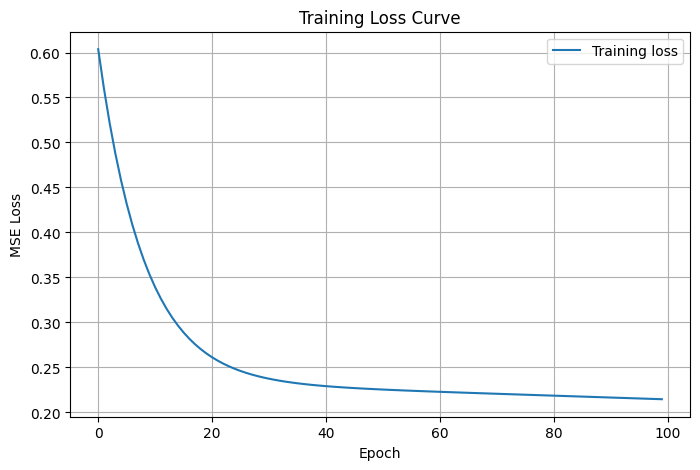

In [10]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(losses[:100], label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


### Generate some test points, predict, visualize the predictions

In [11]:
# --- Generate test data in the same way as training ---
N_test = 2000
x1_test = rng.uniform(-2.0, 2.0, size=N_test)
x2_test = rng.uniform(-2.0, 2.0, size=N_test)
X_test = np.stack([x1_test, x2_test], axis=1)

noise_test = rng.normal(0.0, 0.1, size=N_test)
y_test = 1.2 * np.sin(x1_test) + 0.7 * x2_test - 0.3 * x1_test * x2_test + noise_test
y_test = y_test.reshape(N_test, 1)

# Predict on test set
y_pred_test, _ = forward(X_test, params)

# --- Create a combined DataFrame for plotting ---
df_train = pd.DataFrame({
    "x1": X[:,0], "x2": X[:,1], "y": y.squeeze(),
    "type": "train"
})

df_test = pd.DataFrame({
    "x1": X_test[:,0], "x2": X_test[:,1], "y": y_pred_test.squeeze(),
    "type": "test"
})

df_all = pd.concat([df_train, df_test], ignore_index=True)

# --- Plot ---
fig = px.scatter_3d(
    df_all, x="x1", y="x2", z="y",
    color="type",  # train vs test
    opacity=0.7,
    title="Training data (true) vs Test predictions"
)
fig.update_traces(marker=dict(size=4))
fig.show()


#### Pretty cool, now maybe to wrap it up 
We take some test points, get their predictions, stack them up next to actual labels we get by crunching the test points
to the formula we were trying to learn and see how close they are.
For completeness, we will do that for some training points as well.


In [12]:
import numpy as np
import pandas as pd

def evaluate_and_table(X, y, params, name="dataset", n_samples=20):
    """
    Evaluate the model on a dataset and return a DataFrame with
    a sample of predictions, true values, and errors.
    """
    y_pred, _ = forward(X, params)
    errors = y_pred - y

    df = pd.DataFrame({
        "x1": X[:,0],
        "x2": X[:,1],
        "y_true": y.squeeze(),
        "y_pred": y_pred.squeeze(),
        "error": errors.squeeze()
    })

    # Sample rows for display
    df_sample = df.sample(n_samples, random_state=42).reset_index(drop=True)

    # Summary metrics
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))

    print(f"\n{name} results (sample of {n_samples} rows):")
    print(df_sample.to_string(index=False, float_format="%.3f"))
    print(f"\n{name} summary metrics:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")

    return df_sample, (mae, rmse)

# --- Training set evaluation ---
train_sample, train_metrics = evaluate_and_table(X, y, params, name="Training", n_samples=10)

# --- Test set evaluation ---
test_sample, test_metrics = evaluate_and_table(X_test, y_test, params, name="Testing", n_samples=10)



Training results (sample of 10 rows):
    x1     x2  y_true  y_pred  error
 0.330 -0.120   0.306   0.363  0.057
 0.290  0.193   0.573   0.491 -0.082
 1.862 -1.029   0.934   1.041  0.107
 0.610  0.595   0.991   0.984 -0.008
 0.272 -0.267   0.040   0.199  0.159
 0.339  0.840   0.893   0.905  0.011
 1.584 -1.021   1.061   0.961 -0.100
-1.796  1.628   0.905   0.768 -0.138
 0.214  1.720   1.519   1.409 -0.110
 1.147  1.205   1.364   1.430  0.066

Training summary metrics:
  MAE  = 0.0864
  RMSE = 0.1093

Testing results (sample of 10 rows):
    x1     x2  y_true  y_pred  error
-1.981  1.177   0.343   0.340 -0.003
 0.111  1.371   1.040   1.073  0.033
-0.981  0.649  -0.347  -0.370 -0.023
 1.805 -1.774   0.864   0.847 -0.017
-1.435  0.595  -0.511  -0.467  0.044
-0.860 -1.983  -2.730  -2.803 -0.073
 1.246 -1.527   0.636   0.621 -0.015
-0.915 -0.385  -1.308  -1.338 -0.030
-0.946  1.297   0.170   0.321  0.151
-1.943  1.379   0.873   0.554 -0.319

Testing summary metrics:
  MAE  = 0.0893
  RMSE =

### And now some residuals

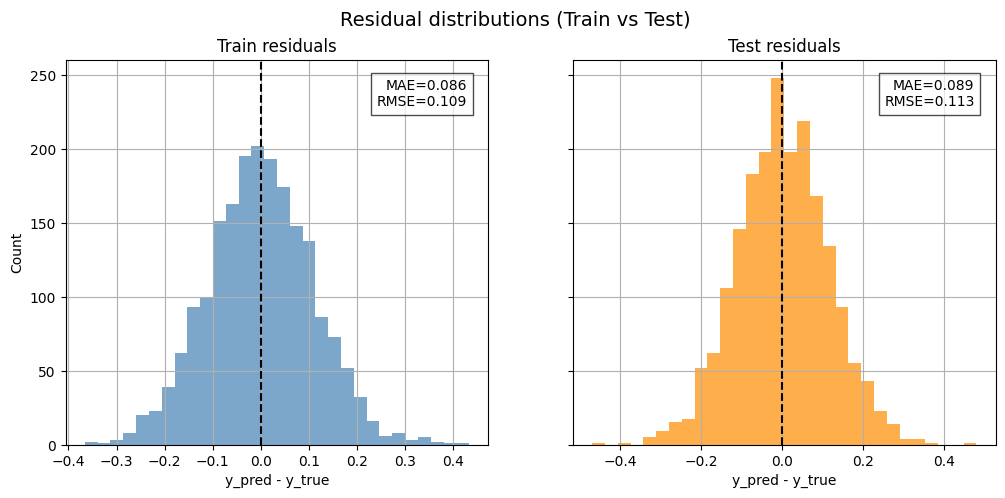

In [13]:
def plot_error_hist_split(train_errors, test_errors, bins=30):
    fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

    # --- Train residuals ---
    axes[0].hist(train_errors, bins=bins, alpha=0.7, color="steelblue")
    axes[0].axvline(0, color="black", linestyle="--")
    axes[0].set_title("Train residuals")
    axes[0].set_xlabel("y_pred - y_true")
    axes[0].set_ylabel("Count")
    axes[0].grid(True)

    mae_train = np.mean(np.abs(train_errors))
    rmse_train = np.sqrt(np.mean(train_errors**2))
    axes[0].text(0.95, 0.95, f"MAE={mae_train:.3f}\nRMSE={rmse_train:.3f}",
                 ha="right", va="top", transform=axes[0].transAxes,
                 fontsize=10, bbox=dict(facecolor="white", alpha=0.7))

    # --- Test residuals ---
    axes[1].hist(test_errors, bins=bins, alpha=0.7, color="darkorange")
    axes[1].axvline(0, color="black", linestyle="--")
    axes[1].set_title("Test residuals")
    axes[1].set_xlabel("y_pred - y_true")
    axes[1].grid(True)

    mae_test = np.mean(np.abs(test_errors))
    rmse_test = np.sqrt(np.mean(test_errors**2))
    axes[1].text(0.95, 0.95, f"MAE={mae_test:.3f}\nRMSE={rmse_test:.3f}",
                 ha="right", va="top", transform=axes[1].transAxes,
                 fontsize=10, bbox=dict(facecolor="white", alpha=0.7))

    plt.suptitle("Residual distributions (Train vs Test)", fontsize=14)
    plt.show()

    # --- Collect residuals ---
y_pred_train, _ = forward(X, params)
train_errors = (y_pred_train - y).squeeze()

y_pred_test, _ = forward(X_test, params)
test_errors = (y_pred_test - y_test).squeeze()

# Call with your residuals
plot_error_hist_split(train_errors, test_errors, bins=30)


### Now, how about a scatter plot for y_hat vs y

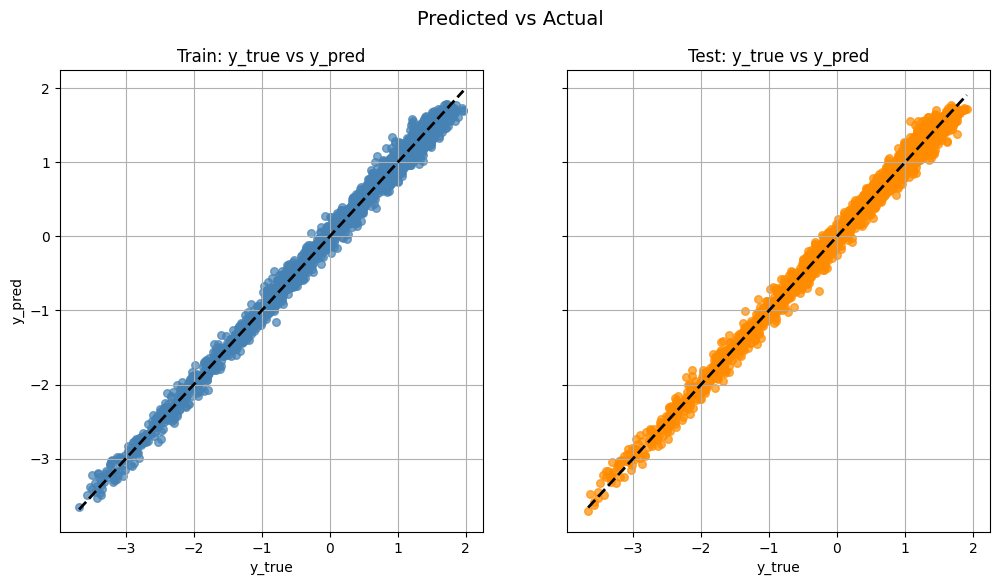

In [14]:
def plot_pred_vs_true(y_train, y_pred_train, y_test, y_pred_test):
    fig, axes = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

    # --- Training set ---
    axes[0].scatter(y_train, y_pred_train, alpha=0.7, color="steelblue", s=30)
    axes[0].plot([y_train.min(), y_train.max()],
                 [y_train.min(), y_train.max()],
                 "k--", lw=2)  # diagonal line
    axes[0].set_title("Train: y_true vs y_pred")
    axes[0].set_xlabel("y_true")
    axes[0].set_ylabel("y_pred")
    axes[0].grid(True)

    # --- Test set ---
    axes[1].scatter(y_test, y_pred_test, alpha=0.7, color="darkorange", s=30)
    axes[1].plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()],
                 "k--", lw=2)  # diagonal line
    axes[1].set_title("Test: y_true vs y_pred")
    axes[1].set_xlabel("y_true")
    axes[1].grid(True)

    plt.suptitle("Predicted vs Actual", fontsize=14)
    plt.show()

# Example call:
y_pred_train, _ = forward(X, params)
y_pred_test, _  = forward(X_test, params)

plot_pred_vs_true(y, y_pred_train, y_test, y_pred_test)


### Pretty
We can probably do even better if we add more neurons and/or extra hidden layers, or possibly just create more data

### Pytorch
Now, let's see what would it would take to train the same model using PyTorch

SimpleMLP(
  (hidden): Linear(in_features=2, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=1, bias=True)
)
Epoch    0 | Training Loss: 1.6064 | Test Loss: 1.5334
Epoch   10 | Training Loss: 0.0781 | Test Loss: 0.0829
Epoch   20 | Training Loss: 0.0468 | Test Loss: 0.0491
Epoch   30 | Training Loss: 0.0222 | Test Loss: 0.0243
Epoch   40 | Training Loss: 0.0191 | Test Loss: 0.0208
Epoch   50 | Training Loss: 0.0174 | Test Loss: 0.0192
Epoch   60 | Training Loss: 0.0167 | Test Loss: 0.0182
Epoch   70 | Training Loss: 0.0174 | Test Loss: 0.0189
Epoch   80 | Training Loss: 0.0156 | Test Loss: 0.0170
Epoch   90 | Training Loss: 0.0153 | Test Loss: 0.0166
Epoch  100 | Training Loss: 0.0151 | Test Loss: 0.0166
Epoch  110 | Training Loss: 0.0152 | Test Loss: 0.0163
Epoch  120 | Training Loss: 0.0156 | Test Loss: 0.0168
Epoch  130 | Training Loss: 0.0148 | Test Loss: 0.0160
Epoch  140 | Training Loss: 0.0150 | Test Loss: 0.0159
Epoch  150 | Training Loss: 0.0151 | Tes

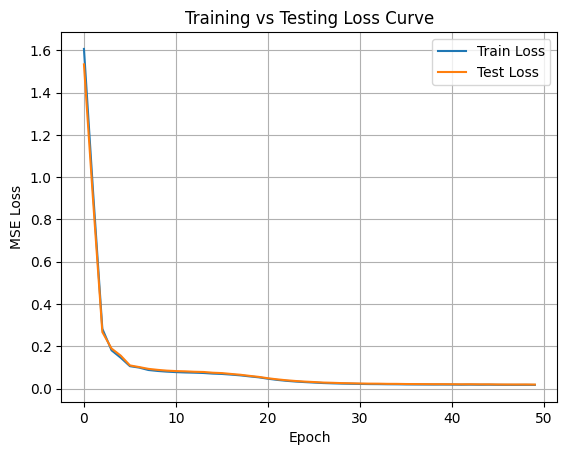

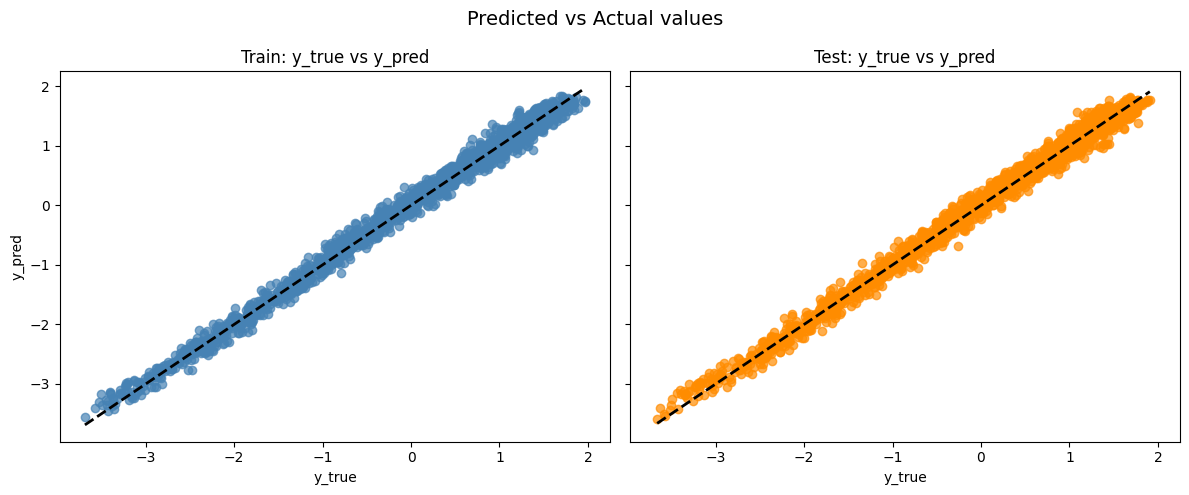

Manual NN - Train Loss: 0.0059745135808915726 | Test Loss: 0.006333978961170515
PyTorch NN - Train Loss: 0.0071001192554831505 | Test Loss: 0.0075861490331590176


In [15]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Convert your NumPy arrays to torch tensors
X_train_torch = torch.from_numpy(X).float()     # shape (200, 2)
y_train_torch = torch.from_numpy(y).float()     # shape (200, 1)
X_test_torch  = torch.from_numpy(X_test).float()
y_test_torch  = torch.from_numpy(y_test).float()

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 4)   # (in=2, hidden=4)
        self.output = nn.Linear(4, 1)   # (hidden=4, out=1)

    def forward(self, x):
        h = torch.sigmoid(self.hidden(x))
        y_hat = self.output(h)
        return y_hat

model = SimpleMLP()
print(model)

# Bundle features and labels into a dataset
train_dataset = TensorDataset(X_train_torch, y_train_torch)

# Make DataLoader
# since this is only a dataset of 200 points, we will just set the batch be as big ad the dataset
# still making it batching for educational purposes so we know what batching looks like in torch
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)


loss_function = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.05)

n_epochs = 1000
losses_train = []
losses_test = []

def calculate_and_record_loss(model, X, y, loss_history):
    model.eval()
    with torch.no_grad():
        y_hat = model(X)
        loss = loss_function(y_hat, y).item()
        loss_history.append(loss)
        model.train()
        return loss_history

for epoch in range(n_epochs):
    for X_batch, y_batch in train_loader:
        # Forward
        y_hat_batch = model(X_batch)
        loss_batch = loss_function(y_hat_batch, y_batch)

        # Backward
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # Get the epoch stats
    losses_train = calculate_and_record_loss(model, X_train_torch, y_train_torch, losses_train)
    losses_test = calculate_and_record_loss(model, X_test_torch, y_test_torch, losses_test)


    if epoch % 10 == 0:
        print(f"Epoch {epoch:4d} | Training Loss: {losses_train[-1]:.4f} | Test Loss: {losses_test[-1]:.4f}")


model.eval()  # switch to evaluation mode

with torch.no_grad():
    y_pred_train = model(X_train_torch)
    y_pred_test  = model(X_test_torch)

import matplotlib.pyplot as plt

plt.plot(losses_train[:50], label="Train Loss")
plt.plot(losses_test[:50], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Testing Loss Curve")
plt.legend()
plt.grid(True)
plt.show()



y_train_true = y_train_torch.squeeze().cpu().numpy()
y_test_true  = y_test_torch.squeeze().cpu().numpy()

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

# Training set
axes[0].scatter(y_train_true, y_pred_train, alpha=0.7, color="steelblue")
axes[0].plot([y_train_true.min(), y_train_true.max()],
             [y_train_true.min(), y_train_true.max()],
             "k--", lw=2)  # diagonal
axes[0].set_title("Train: y_true vs y_pred")
axes[0].set_xlabel("y_true")
axes[0].set_ylabel("y_pred")

# Test set
axes[1].scatter(y_test_true, y_pred_test, alpha=0.7, color="darkorange")
axes[1].plot([y_test_true.min(), y_test_true.max()],
             [y_test_true.min(), y_test_true.max()],
             "k--", lw=2)
axes[1].set_title("Test: y_true vs y_pred")
axes[1].set_xlabel("y_true")

plt.suptitle("Predicted vs Actual values", fontsize=14)
plt.tight_layout()
plt.show()


# --- Manual model evaluation ---
y_pred_train_manual, _ = forward(X, params)
y_pred_test_manual, _  = forward(X_test, params)

final_train_loss_manual = mse_loss(y_pred_train_manual, y)
final_test_loss_manual  = mse_loss(y_pred_test_manual, y_test)

# We need to divide by two because torch doesn't divide by 2 when it calculates the loss
final_train_loss_torch = loss_function(y_pred_train, y_train_torch).item() / 2
final_test_loss_torch  = loss_function(y_pred_test, y_test_torch).item() / 2

print("Manual NN - Train Loss:", final_train_loss_manual, "| Test Loss:", final_test_loss_manual)
print("PyTorch NN - Train Loss:", final_train_loss_torch, "| Test Loss:", final_test_loss_torch)




### Now, really to wrap it up, something cool
We gonna plot the true surface via training labels as the reference cloud, and then overlay test predictions from both models to see how well they fit that surface.

In [16]:
import pandas as pd
import plotly.express as px

n_points = 100

# === Manual model: 100 new test points ===
x1_new = rng.uniform(-2.0, 2.0, size=n_points)
x2_new = rng.uniform(-2.0, 2.0, size=n_points)
X_test_manual = np.stack([x1_new, x2_new], axis=1)
y_pred_test_manual, _ = forward(X_test_manual, params)

df_test_manual = pd.DataFrame({
    "x1": X_test_manual[:,0],
    "x2": X_test_manual[:,1],
    "y": y_pred_test_manual.squeeze(),
    "group": "Manual Test Predictions"
})

# === PyTorch model: 100 new test points ===
X_test_torch_new = 4.0 * torch.rand(n_points, 2) - 2.0
with torch.no_grad():
    y_pred_test_torch = model(X_test_torch_new).cpu().numpy()

df_test_torch = pd.DataFrame({
    "x1": X_test_torch_new[:,0].numpy(),
    "x2": X_test_torch_new[:,1].numpy(),
    "y": y_pred_test_torch.squeeze(),
    "group": "Torch Test Predictions"
})

# === True surface: training labels ===
df_train_true = pd.DataFrame({
    "x1": X[:,0],
    "x2": X[:,1],
    "y": y.squeeze(),
    "group": "True Train Labels"
})

# Combine
df_all = pd.concat([df_train_true, df_test_manual, df_test_torch])

# Plot
fig = px.scatter_3d(
    df_all,
    x="x1", y="x2", z="y",
    color="group", opacity=0.7,
    title="True Surface vs Manual & Torch Predictions",
    color_discrete_map={
        "True Train Labels": "green",
        "Manual Test Predictions": "yellow",
        "Torch Test Predictions": "red"
    }
)

fig.update_traces(marker=dict(size=3))
fig.show()
